# Grapher

## Dataset

- `#chrom`: This column represents the chromosome number where the genetic variant is located.

- `pos`: This is the position of the genetic variant on the chromosome.

- `ref`: This column represents the reference allele (or variant) at the genomic position.

- `alt`: This is the alternate allele observed at this position.

- `rsids`: This stands for reference SNP cluster ID. It's a unique identifier for each variant used in the dbSNP database.

- `nearest_genes`: This column represents the gene which is nearest to the variant.

- `pval`: This represents the p-value, which is a statistical measure for the strength of evidence against the null hypothesis.

- `mlogp`: This represents the minus log of the p-value, commonly used in genomic studies.

- `beta`: The beta coefficient represents the effect size of the variant.

- `sebeta`: This is the standard error of the beta coefficient.

- `af_alt`: This is the allele frequency of the alternate variant in the general population.

- `af_alt_cases`: This is the allele frequency of the alternate variant in the cases group.

- `af_alt_controls`: This is the allele frequency of the alternate variant in the control group.

- `causal`: This binary column indicates whether the variant is determined to be causal (1) or not (0).

- `LD`: This binary column indicates whether the variant is determined to be in linkage disequilibrium (1) or not (0).

- `lead`: This string column contains the rsid of the SNP of which the variant is in LD with.

- `lead_in_rsids`: This boolean column indicates whether the rsid in the `lead` column is in another row of the `rsids` column (`True`) or not (`False`).

- `trait`: This column represents the trait associated with the variant. In this dataset, it is the response to the drug paracetamol and NSAIDs.

## Load libraries

In [1]:
import sys
import os
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, average_precision_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils import to_undirected, negative_sampling
import networkx as nx
from scipy.spatial import cKDTree
from typing import List, Dict
import time
import collections

# Print versions of imported libraries
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Torch version: {torch.__version__}")
print(f"Torch Geometric version: {torch_geometric.__version__}")
print(f"NetworkX version: {nx.__version__}")

if torch.cuda.is_available():
    device = torch.device("cuda")          # Current CUDA device
    print(f"Using {torch.cuda.get_device_name()} ({device})")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
else:
    print("CUDA is not available on this device.")

Python version: 3.11.3 (tags/v3.11.3:f3909b8, Apr  4 2023, 23:49:59) [MSC v.1934 64 bit (AMD64)]
NumPy version: 1.24.3
Pandas version: 2.0.1
Matplotlib version: 3.7.1
Scikit-learn version: 1.2.2
Torch version: 2.0.0+cu118
Torch Geometric version: 2.3.1
NetworkX version: 3.0
Using NVIDIA GeForce RTX 3060 Ti (cuda)
CUDA version: 11.8
Number of CUDA devices: 1


## Load data

In [2]:
dtypes = {
    '#chrom': 'string',
    'pos': 'int64',
    'ref': 'string',
    'alt': 'string',
    'rsids': 'string',
    'nearest_genes': 'string',
    'pval': 'float64',
    'mlogp': 'float64',
    'beta': 'float64',
    'sebeta': 'float64',
    'af_alt': 'float64',
    'af_alt_cases': 'float64',
    'af_alt_controls': 'float64',
    'causal': 'int64',
    'LD': 'int64',
    'lead': 'string',
    'lead_in_rsids': 'bool',
    'trait': 'string'
}

data = pd.read_csv('~/Desktop/gwas-graph/FinnGen/data/gwas-causal.csv', dtype=dtypes)

# Assert column names
expected_columns = ['#chrom', 'pos', 'ref', 'alt', 'rsids', 'nearest_genes', 'pval', 'mlogp', 'beta',
                    'sebeta', 'af_alt', 'af_alt_cases', 'af_alt_controls', 'causal', 'LD', 'lead',
                    'lead_in_rsids', 'trait']
assert set(data.columns) == set(expected_columns), "Unexpected columns in the data DataFrame."

# Assert data types
expected_dtypes = {
    '#chrom': 'string',
    'pos': np.int64,
    'ref': 'string',
    'alt': 'string',
    'rsids': 'string',
    'nearest_genes': 'string',
    'pval': np.float64,
    'mlogp': np.float64,
    'beta': np.float64,
    'sebeta': np.float64,
    'af_alt': np.float64,
    'af_alt_cases': np.float64,
    'af_alt_controls': np.float64,
    'causal': np.int64,
    'LD': np.int64,
    'lead': 'string',
    'lead_in_rsids': bool,
    'trait': 'string'
}

for col, expected_dtype in expected_dtypes.items():
    assert data[col].dtype == expected_dtype, f"Unexpected data type for column {col}."

In [3]:
# Check for total number of null values in each column
null_counts = data.isnull().sum()

print("Total number of null values in each column:")
print(null_counts)

Total number of null values in each column:
#chrom                    0
pos                       0
ref                       0
alt                       0
rsids               1366396
nearest_genes        727855
pval                      0
mlogp                     0
beta                      0
sebeta                    0
af_alt                    0
af_alt_cases              0
af_alt_controls           0
causal                    0
LD                        0
lead               20117400
lead_in_rsids             0
trait                     0
dtype: int64


## Data manipulation

### Create new rows per gene

In [4]:
data['nearest_genes'] = data['nearest_genes'].astype(str)

# Assert column 'nearest_genes' is a string
assert data['nearest_genes'].dtype == 'object', "Column 'nearest_genes' is not of string type."

# Split the gene names in the 'nearest_genes' column
split_genes = data['nearest_genes'].str.split(',')

# Flatten the list of split gene names
flat_genes = [item for sublist in split_genes for item in sublist]

# Create a new DataFrame by repeating rows and substituting the gene names
data_new = data.loc[data.index.repeat(split_genes.str.len())].copy()
data_new['nearest_genes'] = flat_genes

# Assert the shape of the new DataFrame is as expected
expected_shape = (len(flat_genes), data.shape[1])
assert data_new.shape == expected_shape, "Shape of the new DataFrame is not as expected."

# Reset index to have a standard index
data = data_new.reset_index(drop=True)

In [5]:
data

,#chrom,pos,ref,alt,rsids,nearest_genes,pval,mlogp,beta,sebeta,af_alt,af_alt_cases,af_alt_controls,causal,LD,lead,lead_in_rsids,trait
0,1,13668,G,A,rs2691328,OR4F5,0.944365,0.024860,-0.005926,0.084918,0.005842,0.005729,0.005863,0,0,rs912813,True,T2D
1,1,14773,C,T,rs878915777,OR4F5,0.844305,0.073501,0.010088,0.051369,0.013495,0.013547,0.013485,0,0,<NA>,False,T2D
2,1,15585,G,A,rs533630043,OR4F5,0.841908,0.074735,0.031464,0.157751,0.001113,0.001125,0.001110,0,0,<NA>,False,T2D
3,1,16549,T,C,rs1262014613,OR4F5,0.343308,0.464316,0.241377,0.254711,0.000561,0.000620,0.000550,0,0,<NA>,False,T2D
4,1,16567,G,C,rs1194064194,OR4F5,0.129883,0.886447,0.130736,0.086319,0.004170,0.004250,0.004154,0,0,<NA>,False,T2D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20565622,23,155697920,G,A,<NA>,<NA>,0.027115,1.566790,-0.013475,0.006097,0.290961,0.286054,0.291879,0,0,<NA>,False,T2D
20565623,23,155698443,C,A,<NA>,<NA>,0.178417,0.748564,-0.069907,0.051951,0.003259,0.003022,0.003304,0,0,<NA>,False,T2D
20565624,23,155698490,C,T,<NA>,<NA>,0.279640,0.553400,-0.020245,0.018725,0.024406,0.024312,0.024423,0,0,<NA>,False,T2D
20565625,23,155699751,C,T,<NA>,<NA>,0.078864,1.103120,-0.011284,0.006421,0.244829,0.241257,0.245498,0,0,<NA>,False,T2D


In [6]:
# Drop rows with NaN values in 'rsids' column
data.dropna(subset=['rsids'], inplace=True)

# Assert that there are no NaN values in the 'rsids' column
assert data['rsids'].isnull().sum() == 0, "NaN values still present in the 'rsids' column."

# Keep only rows with unique values in 'rsids' column
duplicate_mask = data.duplicated(subset='rsids', keep=False)
data = data[~duplicate_mask]

# Assert that there are no duplicate values in the 'rsids' column
assert data['rsids'].duplicated().sum() == 0, "Duplicate values still present in the 'rsids' column."

# Adjust the index if necessary
data.reset_index(drop=True, inplace=True)

## Spec

**Nodes and Their Features**
- There is one types of node: SNP nodes.
- *SNP Nodes*: Each SNP Node is characterized by various features, including `rsids`, `nearest_genes`, `#chrom`, `pos`, `ref`, `alt`, `beta`, `sebeta`, `af_alt`, and `af_alt_cases` columns.

**Edges, Their Features, and Labels**
- Edges represent relationships between nodes. There is one type of edge: SNP-SNP.
- *SNP-SNP Edges*:
  - These edges are undirected, linking an SNP Node (as identified by the `rsids` column) to another SNP Node (as identified by the `lead` column) in the same data row.
  - The label for each edge is determined by the `LD` column in the data:
    - A label of +1 is assigned when `data['LD']` is 1, signifying that the two SNPs are in linkage disequilibrium.
    - A label of -1 is assigned when `data['LD']` is 0, indicating that the two SNPs are not in linkage disequilibrium.

## Graph creation

In [18]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.impute import SimpleImputer
import time
from typing import Dict


def get_unique_snps(data: pd.DataFrame) -> Dict:
    """
    Function to create mappings for SNPs to integer indices.
    """
    assert 'rsids' in data.columns, "rsids column is missing in the data DataFrame."
    assert not data['rsids'].isnull().any(), "rsids column contains NaN values."

    return {snp: idx for idx, snp in enumerate(data['rsids'].unique())}


def preprocess_snp_features(data: pd.DataFrame, snp_to_idx: Dict) -> pd.DataFrame:
    """
    Function to create node feature vectors for SNPs and preprocess categorical and numerical features.
    """
    nan_replacements = {'nearest_genes': 'N/A', '#chrom': 'N/A', 'pos': 0, 'ref': 'N/A', 'alt': 'N/A',
                        'beta': 0, 'sebeta': 0, 'af_alt': 0, 'af_alt_cases': 0}

    # Impute missing values with appropriate replacements
    snp_features = data[data['rsids'].isin(snp_to_idx.keys())]\
        .drop_duplicates(subset='rsids')\
        .set_index('rsids')\
        .fillna(nan_replacements)

    assert snp_features.size > 0, "Features are empty."

    return snp_features


def preprocess_positive_edges(data: pd.DataFrame, snp_to_idx: Dict) -> np.ndarray:
    """
    Function to create positive SNP-SNP edges and preprocess them.
    """
    # Create a copy of the data to not alter the original DataFrame
    data_copy = data.copy()

    # Map 'rsids' and 'lead' columns to their corresponding indices in 'snp_to_idx'
    data_copy['rsids'] = data_copy['rsids'].map(snp_to_idx)
    data_copy['lead'] = data_copy['lead'].map(snp_to_idx)

    # Filter rows where both 'rsids' and 'lead' are not null
    data_copy.dropna(subset=['rsids', 'lead'], inplace=True)

    # Convert 'rsids' and 'lead' columns to integers
    data_copy['rsids'] = data_copy['rsids'].astype(int)
    data_copy['lead'] = data_copy['lead'].astype(int)

    positive_edges_snp_snp = data_copy[data_copy['LD'] == 1][['rsids', 'lead']].values

    assert positive_edges_snp_snp.size > 0, "No positive SNP-SNP edges found."

    # Return a transpose of the edges array to make it compatible with the graph creation function
    return positive_edges_snp_snp.T


def create_networkx_graph(features: pd.DataFrame, edges: np.ndarray, snp_to_idx: Dict) -> nx.Graph:
    """
    Function to create the NetworkX graph.
    """
    assert isinstance(features, pd.DataFrame), "features must be a pandas DataFrame."
    assert isinstance(edges, np.ndarray), "edges must be a numpy ndarray."

    G = nx.Graph()

    # Add nodes and their attributes to the graph
    for snp, attr_dict in features.iterrows():
        if snp not in snp_to_idx:
            print(f"Unexpected SNP in features: {snp}")
        else:
            G.add_node(snp, **attr_dict.to_dict())

    # Track how many duplicate edges are found
    duplicate_edges = 0

    # Add edges to the graph
    for edge in edges.T:
        if edge[0] not in snp_to_idx or edge[1] not in snp_to_idx:
            print(f"Unexpected edge: {edge}")
        elif G.has_edge(edge[0], edge[1]):
            duplicate_edges += 1
        else:
            G.add_edge(edge[0], edge[1])

    print(f"Number of duplicate edges found: {duplicate_edges}")

    return G



assert 'data' in globals(), "data variable is not defined."

start_time = time.time()

snp_to_idx = get_unique_snps(data)
assert len(snp_to_idx) > 0, "No unique SNPs found."
print(f"Number of unique SNPs: {len(snp_to_idx)}")

snp_features = preprocess_snp_features(data, snp_to_idx)

positive_edges_snp_snp = preprocess_positive_edges(data, snp_to_idx)
assert positive_edges_snp_snp.shape[1] > 0, "No positive SNP-SNP edges found."
print(f"Number of positive SNP-SNP edges: {positive_edges_snp_snp.shape[1]}")

graph = create_networkx_graph(snp_features, positive_edges_snp_snp, snp_to_idx)

print(f"Number of nodes: {graph.number_of_nodes()}")
print(f"Number of edges: {graph.number_of_edges()}")

elapsed_time = time.time() - start_time
print(f"Execution time: {elapsed_time} seconds")


Number of unique SNPs: 18295392
Number of positive SNP-SNP edges: 28
Unexpected edge: [ 143247 3185150]
Unexpected edge: [ 257006 9061102]
Unexpected edge: [ 257680 9062407]
Unexpected edge: [ 257891 9062510]
Unexpected edge: [ 258064 9062567]
Unexpected edge: [ 258296 9062717]
Unexpected edge: [  322465 10864726]
Unexpected edge: [  323199 10892004]
Unexpected edge: [  323214 10892007]
Unexpected edge: [  739470 15877441]
Unexpected edge: [  740550 15877691]
Unexpected edge: [  740766 15877739]
Unexpected edge: [  743661 15878422]
Unexpected edge: [  744319 15878543]
Unexpected edge: [  744520 15878579]
Unexpected edge: [  744536 15878585]
Unexpected edge: [  748850 15879863]
Unexpected edge: [  757859 15884096]
Unexpected edge: [  757882 15884104]
Unexpected edge: [  757922 15884124]
Unexpected edge: [  758074 15884226]
Unexpected edge: [  759336 15884860]
Unexpected edge: [  759428 15884874]
Unexpected edge: [  759532 15884891]
Unexpected edge: [  759769 15884956]
Unexpected edge: [

## Graph stats

## Graph visualization

In [19]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# assuming G is your graph and df is your dataframe
G = graph
df = data

# reverse the snp_to_idx dictionary to map indices back to rsids
idx_to_snp = {idx: snp for snp, idx in snp_to_idx.items()}

def draw_graph(G: nx.Graph, df: pd.DataFrame, snp_to_idx: Dict, node_size=10, font_size=8):
    plt.figure(figsize=(20, 20))

    # mapping node indices to positions
    pos = {node: (df.loc[snp_to_idx[node], '#chrom'], df.loc[snp_to_idx[node], 'pos']) for node in G.nodes()}

    edge_colors = ['green' if G.edges[edge]['LD'] == 1 else 'red' for edge in G.edges()]

    nx.draw(G, pos, node_size=node_size, node_color='blue', edge_color=edge_colors)
    
    node_labels = {idx: snp for idx, snp in idx_to_snp.items() if idx in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=font_size, font_color='k')

    plt.axis('off')
    plt.show()

draw_graph(G, df, snp_to_idx)

ConversionError: Failed to convert value(s) to axis units: array(['13668', '14773', '15585', ..., '50801293', '50807630', '50807721'],
      dtype='<U21')

Error in callback <function _draw_all_if_interactive at 0x000002AC945D5C60> (for post_execute):


MemoryError: 

MemoryError: 

<Figure size 2000x2000 with 1 Axes>

In [16]:
df_rsids = set(df['rsids'])
graph_nodes = set(G.nodes())
print("Nodes in the graph but not in the dataframe: ", graph_nodes - df_rsids)
print("RSIDs in the dataframe but not in the graph: ", df_rsids - graph_nodes)

Nodes in the graph but not in the dataframe:  {759428, 9062407, 323214, 143247, 257680, 258064, 739470, 15878543, 15878422, 15884956, 740766, 322465, 757922, 15884963, 9062567, 759336, 748850, 15878579, 15879863, 15884983, 15878585, 758074, 15877691, 15884860, 9062717, 759935, 15884096, 15877441, 15884226, 15884997, 740550, 744520, 15884104, 15884874, 759888, 10864726, 744536, 759769, 15884891, 15884124, 257891, 757859, 10892004, 10892007, 15877739, 759532, 743661, 257006, 323199, 9061102, 9062510, 258296, 757882, 759805, 3185150, 744319}
RSIDs in the dataframe but not in the graph:  set()


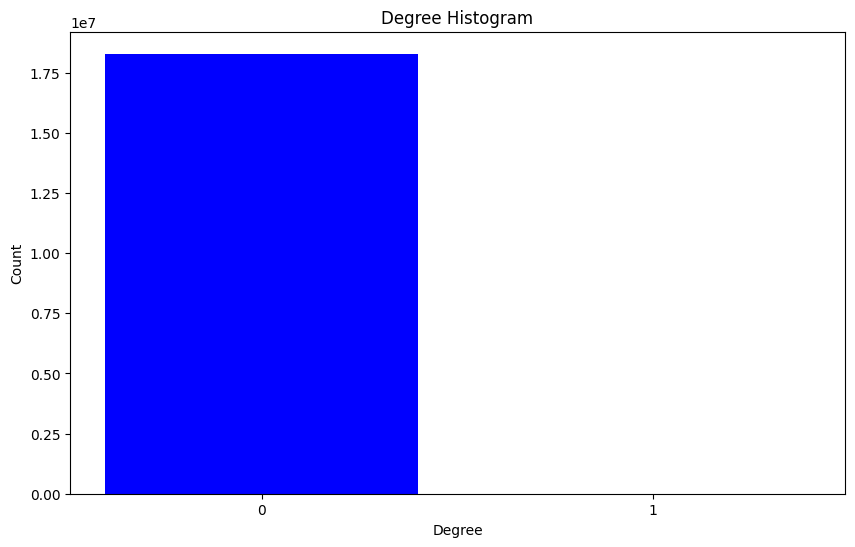

In [9]:
# Compute the degree histogram
degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
degree_count = collections.Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())

plt.figure(figsize=(10, 6))
plt.bar(deg, cnt, width=0.80, color="b")
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.xticks([d for d in deg])
plt.show()


## Export graph

In [10]:
nx.write_graphml(graph, 'graph.graphml')
#graph = nx.read_graphml('graph.graphml')

NetworkXError: GraphML writer does not support <class 'NoneType'> as data values.